# HONIR CCD gain

2013/01分を再解析

2020/10/26 H. Akitaya (PERC/CIT)

2020/10/27 Channge sample region (avoid saturated area.)

In [1]:
from astropy.io import fits
import numpy as np
import glob

In [2]:
files = glob.glob('/home/akitaya/w7/honir/exam/ccdgain201301/*_bt.fits')  # Pre/over-scan region removed images (using hpkossub.py).

In [3]:
files

['/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140061opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140062opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140063opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140064opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140065opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140066opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140067opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140068opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140069opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140070opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140071opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140072opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140073opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140074opt00_bt

69-79の奇数番を使用 (当時のメモより。光源安定)

In [4]:
fns_testimgs = files[8:]
fns_testimgs = fns_testimgs[::2]

In [5]:
fns_testimgs

['/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140069opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140071opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140073opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140075opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140077opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140079opt00_bt.fits']

In [6]:
imgs_testimgs_bt = []
for fn in fns_testimgs:
    hdul = fits.open(fn)
    imgs_testimgs_bt.append(hdul[0].data)

In [7]:
imgs_testimgs_bt_ndarray = np.stack(imgs_testimgs_bt)
del(imgs_testimgs_bt)

In [8]:
testimg_bt_median = np.median(imgs_testimgs_bt_ndarray, axis=0)

In [9]:
testimg_bt_std = np.std(imgs_testimgs_bt_ndarray, axis=0)

In [10]:
img_ave = np.average(testimg_bt_median)
img_std = np.average(testimg_bt_std)

In [11]:
img_ave, img_std, testimg_bt_median.max()

(16413.074, 42.520245, 65421.0)

In [12]:
testimg_bt_median.shape

(4223, 2048)

In [13]:
np.max(testimg_bt_median)

65421.0

In [14]:
import matplotlib.pyplot as plt

In [15]:
plt.imshow(testimg_bt_median, vmin=-1000, vmax = img_ave*2)

In [16]:
testimg_bt_dev = testimg_bt_std **2

In [17]:
plt.imshow(testimg_bt_dev, vmin=000, vmax=5000)

In [18]:
img_ysize = testimg_bt_median.shape[0]

In [19]:
img_xsize = testimg_bt_median.shape[1]

In [20]:
img_xsize_per_ch = int(img_xsize /2)

In [21]:
print(img_xsize, img_ysize, img_xsize_per_ch)

2048 4223 1024


In [22]:
sample_xwidth_per_ch = 256

In [23]:
def get_sample_regions(imgdata, n_port, img_xsize_per_ch, sample_xsize_per_ch, ymin=0, ymax=1000):
    """
    n_port: 1-4
    """
    n_ch = n_port -1
    xmin = img_xsize_per_ch * n_ch +int(img_xsize_per_ch/2) - int(sample_xsize_per_ch/2)
    xmax =  img_xsize_per_ch * n_ch +int(img_xsize_per_ch/2) + int(sample_xsize_per_ch/2)
    return imgdata[ymin:ymax, xmin:xmax+1]

In [24]:
n_port = 1

In [25]:
array_sig = get_sample_regions(testimg_bt_median, n_port, img_xsize_per_ch, sample_xwidth_per_ch, ymin=10, ymax=1000).ravel()
array_dev = get_sample_regions(testimg_bt_dev, n_port, img_xsize_per_ch, sample_xwidth_per_ch, ymin=10, ymax=1000).ravel()

In [26]:
array_sig.max()

31401.533

In [27]:
array_sig.shape, array_sig.max()

((254430,), 31401.533)

In [28]:
array_dev.shape

(254430,)

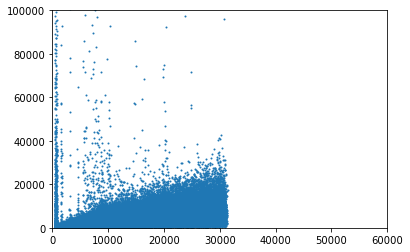

In [29]:
plt.ylim([0, 100000])
plt.xlim([0, 60000])
plt.scatter(array_sig, array_dev, s=1)

In [30]:
x_bin_width = 100

In [31]:
np.max(array_sig)

31401.533

In [32]:
x_max_calc = np.floor(np.max(array_sig)/x_bin_width-1)*x_bin_width

In [33]:
x_max_calc

31300.0

In [34]:
sig_all = []
dev_all = []
err_all = []
x = 0
while (x<= x_max_calc):
    #print(x)
    data_index = ((array_sig > x) & (array_sig <= x+x_bin_width))
    x += x_bin_width
    #print(data_index)
    #and array_sig <= (x+x_bin_width))
    sig_data_prt = array_sig[data_index]
    dev_data_prt = array_dev[data_index]
    
    trues = data_index[data_index==True]
    n_sample = len(trues)
    if n_sample == 0:
        continue
    sig = np.median(sig_data_prt)
    dev = np.median(dev_data_prt)
    error = np.std(dev_data_prt)/np.sqrt(n_sample-1)
    print(sig, dev, error, n_sample)
    sig_all.append(sig)
    dev_all.append(dev)
    err_all.append(error)

384.79395 60.85626 38.232864228015664 3
486.18408 134.29164 18.636037284028163 10550
541.7916 152.25449 42.57580752554725 37815
648.61536 179.57018 20.942590650671196 28024
744.7981 204.76167 21.867345376061195 21371
844.447 236.34207 68.73410245562019 12404
946.369 259.6338 2.163851970396059 7678
1044.8623 281.49365 2.750799323780166 5946
1145.0769 319.06656 3.6888044126533237 3729
1243.4667 343.5195 5.765950208881276 1907
1349.1538 369.43668 7.188790074430967 1439
1463.1697 400.68472 15.534957825520388 2634
1548.7051 433.19025 44.7335297264277 3441
1646.6833 450.62802 43.90847998935783 2985
1739.7727 465.2344 8.182182420767871 1784
1848.0669 504.45148 10.115108635739917 1305
1946.4698 524.3314 11.994009191274545 1036
2048.0415 563.881 14.74785616301237 796
2151.1821 556.5574 17.773090587423006 621
2247.4312 630.7998 18.889906160247453 563
2347.0312 608.78357 21.87103140392642 542
2448.0713 649.3304 21.74227865945632 519
2549.6777 714.80756 20.175383194941645 528
2649.6401 744.17725 2

23845.406 5770.2676 271.20428313595556 224
23947.502 5854.3574 315.43821379951885 222
24049.256 5912.924 289.93786239381114 225
24150.418 6389.568 271.2214006936498 238
24248.082 6360.9805 273.9548288453867 252
24353.164 6427.465 308.08079470253887 230
24454.338 5970.2354 291.82808848262493 222
24547.146 5983.648 245.86507526549536 252
24651.115 6051.1313 277.96337632871746 233
24745.605 5916.2905 815.0631115947533 234
24850.03 6577.214 462.6265619378697 234
24956.512 5784.2617 285.79547233025136 248
25047.355 6433.2075 303.3489721381083 230
25150.441 5650.812 306.54727423769134 225
25255.477 6345.5225 288.4539904541689 232
25346.092 6520.502 300.0456422318568 229
25451.502 5950.222 331.4836136594189 232
25552.486 6253.158 275.1842644839012 245
25649.89 7077.2744 305.76242180628793 228
25751.215 6760.469 298.9724653361541 242
25848.422 5903.732 324.7619178242729 248
25950.957 6114.883 297.27841158236333 217
26043.922 5915.0713 275.1886900496473 251
26145.967 6485.453 336.8550864386042 

In [35]:
plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt="o")
plt.grid()
plt.xlabel('Count [ADU]')
plt.ylabel('Deviation [ADU^2]')
plt.xlim([0, x_max_calc])
plt.show()

In [36]:
from scipy import optimize

In [37]:
def photontransfer_curve(x, gain, ro):
    return x/gain + (ro/gain)**2

In [38]:
par, cov = optimize.curve_fit(photontransfer_curve, sig_all, dev_all,  sigma=err_all, p0=(0.1, 4.0))

In [39]:
par

array([ 3.92206006, 18.70917938])

In [40]:
cov

array([[2.08540415e-04, 9.05218537e-03],
       [9.05218537e-03, 8.34756062e-01]])

In [41]:
x_fit = np.linspace(0, 2500, 26)

In [42]:
y_fit = photontransfer_curve(x_fit, par[0], par[1])

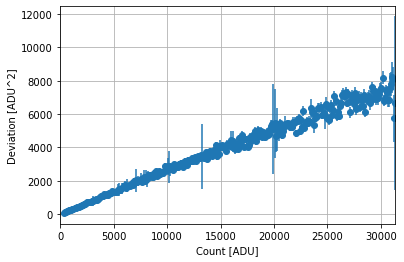

In [43]:
plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt="o")
plt.plot(x_fit, y_fit)
plt.grid()
plt.xlabel('Count [ADU]')
plt.ylabel('Deviation [ADU^2]')
plt.xlim([0, x_max_calc])
plt.show()

In [44]:
def analyse_photontransfer_curve(sig_all, dev_all, err_all, p0=(3, 10.0), sig_max=None):
    sig_all_ndarray = np.array(sig_all)
    dev_all_ndarray = np.array(dev_all)
    err_all_ndarray = np.array(err_all)
    if sig_max != None:
        filter_matrix = sig_all_ndarray < sig_max
        sig_all_ndarray = sig_all_ndarray[filter_matrix]
        dev_all_ndarray = dev_all_ndarray[filter_matrix]
        err_all_ndarray = err_all_ndarray[filter_matrix]
    par, cov = optimize.curve_fit(photontransfer_curve, sig_all_ndarray, dev_all_ndarray, 
                                  sigma=err_all_ndarray, p0=p0, absolute_sigma=False)
    return par, cov

In [45]:
def plt_photontransfer_curve(sig_all, dev_all, err_all, par):
    x_fit = np.linspace(0, np.max(sig_all)*0.8, 100)
    y_fit = photontransfer_curve(x_fit, par[0], par[1])
    plt.grid()
    plt.xlabel('Count [ADU]')
    plt.ylabel('Deviation [ADU^2]')
    plt.xlim([0, x_max_calc])
    plt.ylim([0,10000])
    plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt=".")
    plt.plot(x_fit, y_fit, color='r', linewidth=3)
    plt.show()

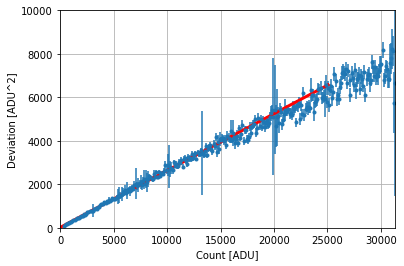

In [46]:
par, cov = analyse_photontransfer_curve(sig_all, dev_all, err_all, sig_max=20000)
plt_photontransfer_curve(sig_all, dev_all, err_all, par)

In [47]:
def get_sample_region(img_sig, img_dev, n_port, sample_xsize_per_ch=256):
    img = img_sig
    img_ysize = img.shape[0]
    img_xsize = img.shape[1]
    img_xsize_per_ch = int(img_xsize /4)
    n_ch = n_port -1
    xmin = int(img_xsize_per_ch * n_ch + img_xsize_per_ch/2 - sample_xsize_per_ch/2)
    xmax =  int(img_xsize_per_ch * n_ch + img_xsize_per_ch/2 + sample_xsize_per_ch/2)
    print('img_sig.shape {}'.format(img_sig.shape))
    print(xmin, xmax)
    array_sig = img_sig[:, xmin:xmax+1].ravel()
    array_dev= img_dev[:, xmin:xmax+1].ravel()
    return array_sig, array_dev

In [48]:
def calc_statistics_in_sample_region(array_sig, array_dev, count_bin_width=100):
    sig_all = []
    dev_all = []
    err_all = []
    count = 0
    count_max_calc = np.floor(np.max(array_sig)/count_bin_width-1)*count_bin_width
    while (count<= count_max_calc):
        #print(x)
        data_index = ((array_sig > count) & (array_sig <= count+count_bin_width))
        count += count_bin_width
        #print(data_index)
        #and array_sig <= (x+x_bin_width))
        sig_data_prt = array_sig[data_index]
        dev_data_prt = array_dev[data_index]
    
        trues = data_index[data_index==True]
        n_sample = len(trues)
        #print(n_sample)
        if n_sample == 0:
            continue
        sig = np.median(sig_data_prt)
        dev = np.median(dev_data_prt)
        error = np.std(dev_data_prt)/np.sqrt(n_sample-1)
       # print(sig, dev, error, n_sample)
        sig_all.append(sig)
        dev_all.append(dev)
        err_all.append(error)
    return sig_all, dev_all, err_all

## Calculate gains of the port 1-4

Port 1
img_sig.shape (4223, 2048)
128 384


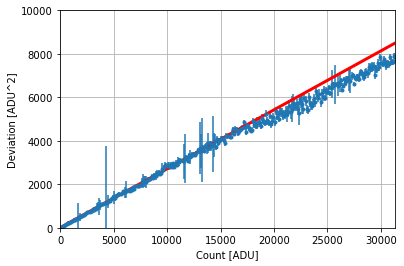

Port 2
img_sig.shape (4223, 2048)
640 896


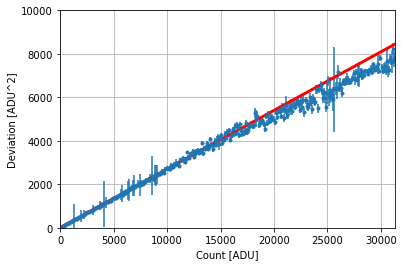

Port 3
img_sig.shape (4223, 2048)
1152 1408


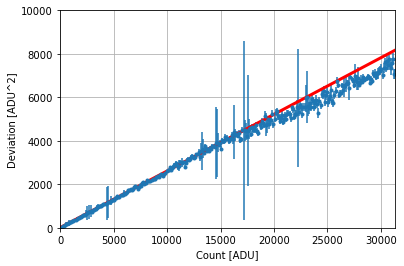

Port 4
img_sig.shape (4223, 2048)
1664 1920


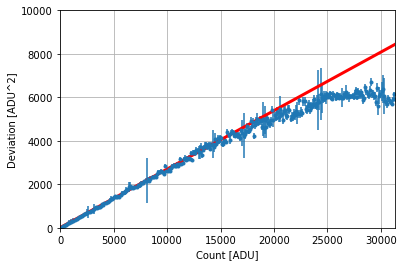

In [49]:
pars = []
covs = []

SIG_MAX = 15000.0  # Fitting range (mag).

for n_port in range(1, 5):
    print('Port {}'.format(n_port))
    array_sig, array_dev = get_sample_region(testimg_bt_median, testimg_bt_dev, n_port)
    sig_all, dev_all, err_all = calc_statistics_in_sample_region(array_sig, array_dev)
    par, cov = analyse_photontransfer_curve(sig_all, dev_all, err_all, sig_max=SIG_MAX)
    plt_photontransfer_curve(sig_all, dev_all, err_all, par)
    pars.append(par)
    covs.append(cov)

In [50]:
pars

[array([3.68778923, 6.23422145]),
 array([3.70839443, 8.27527124]),
 array([3.83751603, 9.49715363]),
 array([3.71446853, 9.12944499])]

In [51]:
covs

[array([[1.18760809e-04, 1.75271927e-02],
        [1.75271927e-02, 4.66051632e+00]]),
 array([[1.02521382e-04, 1.02641821e-02],
        [1.02641821e-02, 3.02655760e+00]]),
 array([[9.20429546e-05, 9.66560473e-03],
        [9.66560473e-03, 2.05026839e+00]]),
 array([[1.24717121e-04, 1.49940401e-02],
        [1.49940401e-02, 3.64789489e+00]])]

In [52]:
i=1
print('#ch gain [e/ADU] err_gain ro[e-] err_ro')
for par, cov in zip(pars, covs):
    print('{:1d} {:12.5f} {:12.5f} {:8.2f} {:8.2f}'.format(i, float(par[0]),  float(cov[0][1]), float(par[1]), float(cov[1][1])))
    i += 1

#ch gain [e/ADU] err_gain ro[e-] err_ro
1      3.68779      0.01753     6.23     4.66
2      3.70839      0.01026     8.28     3.03
3      3.83752      0.00967     9.50     2.05
4      3.71447      0.01499     9.13     3.65


当時の解析と1.5倍近く異なる。

    # CCD gain measurment
    # for 2013/01

    # 2013/03/01
    
    # ch1
    # 0-10000 ADU fit
    a               = 0.379947         +/- 0.005073     (1.335%)
    b               = -13.5493         +/- 28.45        (210%)
    gain 2.63194603457851 0.0351413808594798
    
    # ch2
    # 0-10000 ADU fit
    a               = 0.384998         +/- 0.008447     (2.194%)
    b               = -13.5508         +/- 46.35        (342%)
    gain 2.5974160904732 0.0569882797215235
    
    
    # ch3
    # 0-10000 ADU fit
    a               = 0.360213         +/- 0.005382     (1.494%)
    b               = 20.7648          +/- 31.77        (153%)
    gain 2.77613523109938  0.0414786801525121
    
    # ch4 
    # 0-10000 ADU fit
    a               = 0.36321          +/- 0.007142     (1.966%)
    b               = 20.5132          +/- 40.43        (197.1%)
    gain 2.75322816001762  0.0541382547805563
    
    # 4 chs
    average 2.6896813790422 0.088239664896097 4
